# LALSimulation
This uses LALSimulation. The reason this has been put on pause as ```XLAL Error - XLALSimIMRSpinAlignedEOBModes: Ringdown frequency > Nyquist frequency!``` is an error that keeps popping up because I'm struggling to actually change the parameter_check() values.

We're using OOP to create a LALCompactBinaryCoalescenseGenerator object: https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/classlalsimulation_1_1gwsignal_1_1core_1_1waveform_1_1_l_a_l_compact_binary_coalescence_generator.html

In [2]:
%matplotlib inline

import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wv
from astropy import units as u
import matplotlib.pyplot as plt

/tmp/ipykernel_130/1735859240.py:3: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


/home/cschun/.local/lib/python3.9/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


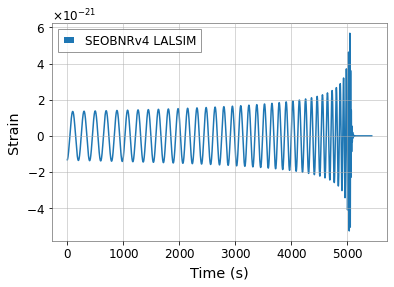

/home/cschun/.local/lib/python3.9/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


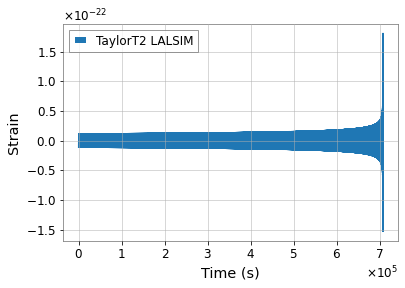

In [3]:
labels = ['SEOBNRv4', 'TaylorT2', 'SEOBNRv4_ROM_NRTidalv2_NSBH']
m1 = [30, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
m2 = [20, 1.5, 1.5]

# we need to figure out all these values
dt = 1./4096
df = 1./4
dist = 100
fmin = 10
fref = 20
fmax = 2000

lalsim_data = []
if __name__=='__main__':
    approxs = [lalsimulation.SEOBNRv4, lalsimulation.TaylorT2, lalsimulation.SEOBNRv4_ROM_NRTidalv2_NSBH]
    parentWV = wv.CompactBinaryCoalescenceGenerator()
    
    for i in range(2):
        waveform = wv.LALCompactBinaryCoalescenceGenerator(approxs[i])
        lalsim_data.append(waveform.generate_td_waveform(mass1 = m1[i]*u.solMass,
                                                         mass2 = m2[i]*u.solMass,
                                                         deltaT = dt*u.s, 
                                                         deltaF = df*u.Hz,
                                                         distance = dist*u.Mpc,
                                                         f_max = fmax*u.Hz))

        plt.plot(range(len(lalsim_data[i][i])), lalsim_data[i][0], label=labels[i]+" LALSIM") #solve the time issue

        plt.ylabel('Strain')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

# PyCBC
For this I tried using PyCBC, with https://pycbc.org/pycbc/latest/html/waveform.html as a reference point.

The most common error I'm receiving is ```XLAL Error - SEOBNRv4ROMCore (LALSimIMRSEOBNRv4ROM.c:772): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH```. Which I'm receiving as an error for LALSimulation as well when I attempt to use SEOBNRv4_ROM_NRTidalv2_NSBH. Besides this, PyCBC seems to be working far better than LALSimulation, and it's also built on using LALSimulation.

This is also very loud at 0? Which I don't like the look of.

In [4]:
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [ ]:
m1 = [30, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
m2 = [20, 1.5, 1.5]
for i in range(2):
    hp, hc = get_td_waveform(approximant=labels[i], mass1=m1[i], mass2=m2[i], delta_t=dt,
                             delta_f=df, distance=dist, f_final = fmax, f_lower = fmin)
    plt.plot(hp.sample_times, hp, label=labels[i])
    print(hp.sample_times)
    plt.ylabel('Strain')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()

[-8.45980853 -8.45956439 -8.45932025 ...  0.09390241  0.09414655
  0.09439069]


# Data Whitening

In [ ]:
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import numpy as np

In [ ]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [ ]:
j = 1
hp, hc = get_td_waveform(approximant=labels[j], mass1=m1[j], mass2=m2[j], delta_t=1.0/4096,
                         f_lower=20, distance=100, f_ref=20, delta_f=1./4, f_final = 2048)
def preprocessing(data, time):
    fs = 4096
    NFFT = 1*fs
    pxx, freq = mlab.psd(data, Fs = fs, NFFT = NFFT) #obtains transformed signal via welch's psd
    psd = interp1d(freq, pxx) # constructs the interpolated function
    dt = time[1]-time[0] # time binning
    whitened_SEOBNRv4 = whiten(data, psd, dt)

    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_SEOBNRv4 = filtfilt(bb, ab, whitened_SEOBNRv4)
    strain_L1_shift = np.roll(whitened_SEOBNRv4,int(fs))
    plt.plot(time, strain_L1_shift, label=labels[i])
    plt.xlim([-5, 5])
    plt.show()

processed = preprocessing(hp, hp.sample_times)

In [ ]:
import h5py

# LIGO-specific readligo.py 
import readligo as rl

In [ ]:
fn_H1 = 'H-H1_GWOSC_O3b_4KHZ_R1-1256697856-4096.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')

fs = 4096
time = time_H1
dt = time[1] - time[0]

def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

NFFT = 1*fs
fmin = 10
fmax = 2000
tevent = (time[-1]-time[0])/2+time[0]

Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)

strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)

tevent = (time[-1]-time[0])/2+time[0]
plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
#plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

In [ ]:
tevent = (time[-1]-time[0])/2+time[0]
plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
#plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

In [ ]:
(time[-1]-time[0])/2+time[0]

# Other Resources
- https://github.com/Chaitany1729/nn_for_gw
- https://github.com/eric-moreno/Anomaly-Detection-Autoencoder
- https://github.com/timothygebhard/ggwd/

In [ ]:
%matplotlib inline

import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wv
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import h5py
import random

from astropy import units as u
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz 
import readligo as rl

In [ ]:
labels = ['SEOBNRv4', 'TaylorT2', 'SEOBNRv4_ROM_NRTidalv2_NSBH']
mass1 = [2, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
mass2 = [95, 1.5, 1.5]

# we need to figure out all these values
dt = 1./4096
df = 1./4
dist = 100
fmin = 10
fref = 20
fmax = 2000
fs = 4096
NFFT = 1./fs

In [ ]:
lalsim_data = []

if __name__=='__main__':
    approxs = [lalsimulation.SEOBNRv4, lalsimulation.TaylorT2, lalsimulation.SEOBNRv4_ROM_NRTidalv2_NSBH]
    parentWV = wv.CompactBinaryCoalescenceGenerator()
    
    for i in [0]:
        while len(lalsim_data) < 100:
            m1 = random.randint(mass1[i],mass2[i])
            m2 = random.randint(mass1[i],mass2[i])
            while m1/m2 > 10:
                m2 = random.randint(2,95)
            waveform = wv.LALCompactBinaryCoalescenceGenerator(approxs[i])
            lalsim_data.append(waveform.generate_td_waveform(mass1 = m1*u.solMass,
                                                             mass2 = m2*u.solMass,
                                                             deltaT = dt*u.s, 
                                                             deltaF = df*u.Hz,
                                                             distance = dist*u.Mpc,
                                                             f_max = fmax*u.Hz))

        plt.plot(range(len(lalsim_data[i][0])), lalsim_data[i][0], label=labels[i]+" LALSIM") #solve the time issue

        plt.ylabel('Strain')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

In [ ]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [ ]:
def SEOBNRv4_preprocessing(data, time, dt):
    pxx, freq = mlab.psd(data, Fs = fs, NFFT = NFFT) #obtains transformed signal via welch's psd
    psd = interp1d(freq, pxx) # constructs the interpolated function
    whitened_SEOBNRv4 = whiten(data, psd, dt)

    #bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    #strain_SEOBNRv4 = filtfilt(bb, ab, whitened_SEOBNRv4)
    shift = (time[0]-time[-1])/4
    strain_L1_shift = np.roll(whitened_SEOBNRv4,int(shift))
    return strain_L1_shift

processed_SEOBNRv4 = []

for i in range(100):
    time = np.linspace(-len(lalsim_data[i][0]), 0, len(lalsim_data[i][0]))
    processed_SEOBNRv4.append(SEOBNRv4_preprocessing(lalsim_data[i][0], time, dt))
    
plt.plot(time, processed_SEOBNRv4[-1], label=labels[0])
plt.show()

In [ ]:
fn_H1 = 'H-H1_GWOSC_O3b_4KHZ_R1-1256697856-4096.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')

time = time_H1
dt = time[1] - time[0]
tevent = (time[-1]-time[0])/2+time[0]

Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
psd_H1 = interp1d(freqs, Pxx_H1)

strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)

tevent = (time[-1]-time[0])/2+time[0]

In [ ]:
plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.xlim([-0.1,0.04])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')